In [55]:
%matplotlib inline
import pandas as pd
import re
import os, itertools, csv
import bleach
import progressbar
from bs4 import BeautifulSoup
from datetime import datetime
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, VotingClassifier, VotingRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve
from sklearn.impute import SimpleImputer

In [56]:
df = pd.read_csv('../data/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


In [57]:
############  try to get month
# bs = BeautifulSoup(df.loc[0,'Page content'], 'html.parser')

    
# time = bs.find('time')
# if time.has_attr('datetime'):
#     time = time['datetime']
#     time = datetime.strptime(time, '%a, %d %b %Y %H:%M:%S %z')
#     weekday = time.weekday()
#     print(time)
# #     month = time.month
#     print(weekday)
#     if weekday > 4 :
#         weekday = 0
#     else:
#         weekday = 1


In [58]:
import nltk
from nltk import word_tokenize

def count_words(text):
    return len(text.split())

def count_words_in_quotes(text):
    x = re.findall("'.'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

def data_preprocess(text):
    bs = BeautifulSoup(text, 'html.parser')
    
    title = bs.find(class_="title").text
    content = bs.find(class_="article-content").text
    channel = bs.find("article")["data-channel"]
#     tag = bs.find(class_="article-topics").text
#     match = re.compile('Topics:')
#     tag = match.sub(r' ', tag)
    topic_tags = bs.find('footer', class_="article-topics").find_all('a')
    topics = [t.get_text() for t in topic_tags]
    tag = ' '.join( topics )
    fig_count = len(bs.find_all('img'))
    link_count = len(bs.find_all('a'))
    # modify area
    word_count = len(text.split())
    #capital_word_count = sum(map(str.isupper,text.split()))
    #sentence_count = len(nltk.sent_tokenize(text))
    #unique_word_count = len(set(text.split()))
    #htags_count = re.findall(r'(#w[A-Za-z0-9]*)', text)
    #words_in_quotes_count = count_words_in_quotes(text)
    #stopwords_count = count_stopwords(text)
    #
    
    time = bs.find('time')
    timestamp = np.NaN
    weekday = np.NaN
    month = np.NaN
    ## Dealing with empty value
    if time.has_attr('datetime'):
        time = time['datetime']
        time = datetime.strptime(time, '%a, %d %b %Y %H:%M:%S %z')
        weekday = time.weekday()
        if weekday > 4 :
            weekday = 0
        else:
            weekday = 1
        
        month = time.month
        if month > 5 :
            month = 1
        else:
            month = 0
            
        timestamp = time.timestamp()
    
#     time = bs.find('time')['datetime']
#     time = datetime.strptime(time, '%a, %d %b %Y %H:%M:%S %z')
#     weekday = time.weekday()
#     timestamp = time.timestamp()
#     print(title)
#     print(content)
#     print("channel", channel)
#     print("tag",tag)
    return title, content, tag, channel, fig_count, link_count, weekday, month, timestamp, word_count#, capital_word_count, sentence_count, unique_word_count, htags_count, words_in_quotes_count, stopwords_count

# data_preprocess(df.loc[0,'Page content'])

In [59]:
nltk.download('punkt')
nltk.download('stopwords')

# for train data
# df_small = df.sample(n=100, random_state=0)

train_data = pd.DataFrame(columns=["title", "content", "tag", "channel", "fig_count", "link_count", "weekday", "month", "timestamp", "word_count"])#, "capital_word_count", "sentence_count", "unique_word_count", "htags_count", "words_in_quotes_count", "stopwords_count"])
train_label = pd.DataFrame(columns=["Popularity"])
pgbar = progressbar.ProgressBar(widgets=['Progress: ',progressbar.Percentage(), ' ', progressbar.Bar('#'), progressbar.ETA()])
for i in pgbar(range(len(df))):
    title, content, tag, channel,  fig_count, link_count, weekday, month, timestamp, word_count = data_preprocess(df.loc[i,'Page content'])#, capital_word_count, sentence_count, unique_word_count, htags_count, words_in_quotes_count, stopwords_count= data_preprocess(df.loc[i,'Page content'])
    train_data = train_data.append({ 
                                    "title": title, 
                                    "content": content,
                                    "tag":  tag,
                                    "channel": channel, 
                                    "fig_count":  fig_count,
                                    "link_count":  link_count,
                                    "weekday":  weekday,
                                    "month": month,
                                    "timestamp":  timestamp,
                                    "word_count": word_count
                                    # "capital_word_count": capital_word_count,
                                    # "sentence_count": sentence_count,
                                    # "unique_word_count": unique_word_count,
                                    # "htags_count": htags_count,
                                    # "words_in_quotes_count": words_in_quotes_count,
                                    # "stopwords_count": stopwords_count
                                    }, ignore_index=True)
    train_label = train_label.append({ "Popularity": df.loc[i, "Popularity"]}, ignore_index=True)
    
train_data.head()


# print(y_train[:,0])
# print(y_train[:,'Popularity'])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Progress: 100% |#################################################|Time: 0:08:52


,title,content,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count
0,NASA's Grand Challenge: Stop Asteroids From De...,There may be killer asteroids headed for Eart...,Asteroid Asteroids challenge Earth Space U.S. ...,world,1,22,1,1,1.371654e+09,658
1,Google's New Open Source Patent Pledge: We Won...,Google took a stand of sorts against patent-l...,Apps and Software Google open source opn pledg...,tech,2,18,1,0,1.364492e+09,390
2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,You've spend countless hours training to be a...,Entertainment NFL NFL Draft Sports Television,entertainment,2,11,1,0,1.399490e+09,1884
3,Cameraperson Fails Deliver Slapstick Laughs,Tired of the same old sports fails and ne...,Sports Video Videos Watercooler,watercooler,1,13,1,1,1.381458e+09,858
4,NFL Star Helps Young Fan Prove Friendship With...,"At 6-foot-5 and 298 pounds, All-Pro NFL star ...",Entertainment instagram instagram video NFL Sp...,entertainment,52,16,1,0,1.397706e+09,2831


In [60]:
label_le = LabelEncoder()
train_data["channel"] = label_le.fit_transform(train_data["channel"].values)
# important
train_data["word_count"] = label_le.fit_transform(train_data["word_count"].values)

old_data = train_data
X_train, X_test, y_train, y_test = train_test_split(old_data, train_label['Popularity'].astype('int'), test_size=0.2, random_state=0)
# print(X_train)
# print(y_train)
tmp_X = X_train
tmp_y = y_train

In [61]:
nltk.download('stopwords')
stop = stopwords.words('english')

def preprocessor(text):
    # remove HTML tags
#     print("text type = ", type(text))
#     print("text  = ", text)
    text = text[0]
#     print("text  = ", text)
#     text = BeautifulSoup(text, 'html.parser').get_text()
#     text = text.decode('utf-8') 
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip())
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
######################
# custom transformer for sklearn pipeline
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols_from, cols_to):
        self.cols_from = cols_from
        self.cols_to = cols_to

    def transform(self, X):
        col_data = pd.DataFrame()
        col_data = X.iloc[:, self.cols_from:self.cols_to]
#         print("shape = ",col_data.shape)
#         print("data = ",col_data)
        return col_data.values
#     return col_data["feature"]

    def fit(self, X, y=None):
        return self

In [63]:
print(type(pd.DataFrame(columns=["word_count"])))

<class 'pandas.core.frame.DataFrame'>


In [64]:
# tags
pipe_title = Pipeline([
                    ('col_extract', ColumnExtractor( cols_from=0, cols_to=1 )),
                    ('vect', TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop) ), 
                    ('clf', RandomForestClassifier(n_estimators=400, max_depth=5, n_jobs=-1))
                ])
pipe_content = Pipeline([
                    ('col_extract', ColumnExtractor( cols_from=1, cols_to=2 )),
                    ('vect', TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop) ), 
                    ('clf', RandomForestClassifier(n_estimators=400, max_depth=5, n_jobs=-1))
                ])
pipe_tag = Pipeline([
                    ('col_extract', ColumnExtractor( cols_from=2, cols_to=3 )),
                    ('vect', HashingVectorizer(n_features=2**10,
                                             preprocessor=preprocessor, 
                                             tokenizer=tokenizer_stem_nostop)),
                    ('clf', LogisticRegression(solver = "liblinear"))
                ])
# names = ['title','content','tag']
names = ['tag']

# for name, clf in zip(names, [pipe_title, pipe_content, pipe_tag]):
for name, clf in zip(names, [pipe_tag]):
#     scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
#                          cv=10, scoring='roc_auc')
#     print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_data[name] = clf.predict_proba(train_data)
    print('Misclassified samples: %d' % ((y_test != y_pred).sum()))
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
  

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Misclassified samples: 2635
Accuracy: 0.5234


In [65]:
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns=['title','content']), train_label['Popularity'].astype('int'), test_size=0.2, random_state=0)


In [66]:
train_data

,title,content,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count
0,NASA's Grand Challenge: Stop Asteroids From De...,There may be killer asteroids headed for Eart...,0.549945,32,1,22,1,1,1.371654e+09,567
1,Google's New Open Source Patent Pledge: We Won...,Google took a stand of sorts against patent-l...,0.568743,28,2,18,1,0,1.364492e+09,299
2,Ballin': 2014 NFL Draft Picks Get to Choose Th...,You've spend countless hours training to be a...,0.483024,7,2,11,1,0,1.399490e+09,1772
3,Cameraperson Fails Deliver Slapstick Laughs,Tired of the same old sports fails and ne...,0.533505,31,1,13,1,1,1.381458e+09,767
4,NFL Star Helps Young Fan Prove Friendship With...,"At 6-foot-5 and 298 pounds, All-Pro NFL star ...",0.427349,7,52,16,1,0,1.397706e+09,2433
...,...,...,...,...,...,...,...,...,...,...
27638,Chief of USAID Doesn't Know Who Created 'Cuban...,The chief of the U.S. Agency for Internationa...,0.476237,32,2,12,1,0,1.396974e+09,349
27639,Photo of Samsung's Rumored Virtual Reality Hea...,"Back in May, reports surfaced claiming that S...",0.468836,28,3,23,1,1,1.404868e+09,347
27640,14 Dogs That Frankly Cannot Take the Heat,There's nothing more helpless than the middle...,0.551493,31,15,23,1,1,1.404995e+09,537
27641,"Yahoo Earnings Beat Estimates, But Core Proble...",Yahoo's profits in the first quarter beat Wal...,0.619656,3,3,17,1,0,1.366145e+09,416


[=======testing different model========]
[auc (10-fold cv)]


[classfier = pipe1]
Misclassified samples: 2451
Accuracy: 0.5567
scores: 0.639 (+/-0.014)
Test AUC: 0.5752


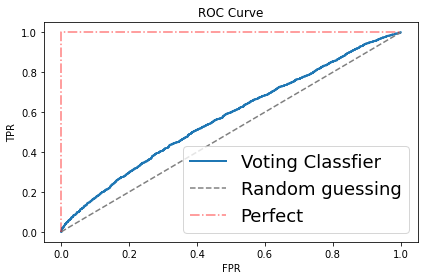



[classfier = pipe2]
Misclassified samples: 2470
Accuracy: 0.5533
scores: 0.644 (+/-0.012)
Test AUC: 0.5735


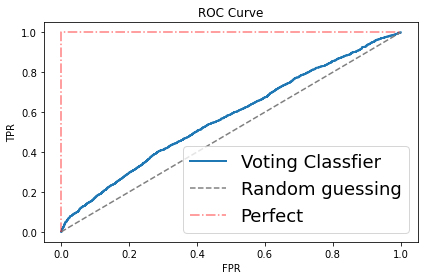



[classfier = pipe3]
Misclassified samples: 2506
Accuracy: 0.5468
scores: 0.628 (+/-0.010)
Test AUC: 0.5621


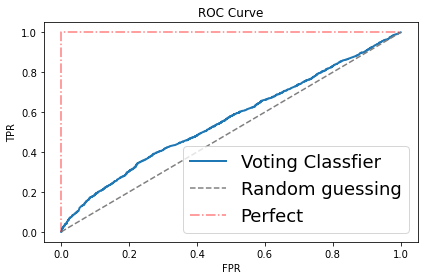



[classfier = pipe4]
Misclassified samples: 2456
Accuracy: 0.5558
scores: 0.627 (+/-0.015)
Test AUC: 0.5692


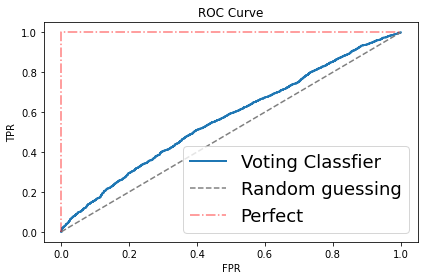



[classfier = pipe5]
Misclassified samples: 2459
Accuracy: 0.5553
scores: 0.645 (+/-0.012)
Test AUC: 0.5740


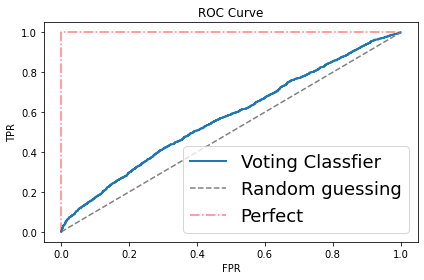



[classfier = pipe6]
Misclassified samples: 2476
Accuracy: 0.5522
scores: 0.646 (+/-0.013)
Test AUC: 0.5741


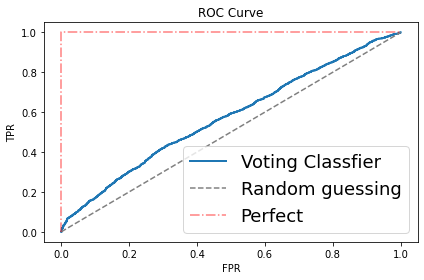

In [67]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
pipe1 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=500, max_depth=15, n_jobs=-1, random_state=1))
                ])
pipe2 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=1))
                ])
# channel,fig_count, link_count, weekday
pipe3 = Pipeline([
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=500, max_depth=1, n_jobs=-1, random_state=1))
                ])
pipe4 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=400, max_depth=25, n_jobs=-1, random_state=1))
                ])
pipe5 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=800, max_depth=10, n_jobs=-1, random_state=1))
                ])
pipe6 = Pipeline([ 
                    ('sc', StandardScaler()),
                    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
                    ('clf', RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=-1, random_state=1))
                ])

print("[=======testing different model========]")

names = ['pipe1','pipe2','pipe3','pipe4','pipe5','pipe6']
print('[auc (10-fold cv)]')
best_clf , best_sc = None, -1
for name, clf in zip(names, [pipe1, pipe2, pipe3, pipe4, pipe5, pipe6]):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
                         cv=10, scoring='roc_auc')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test,
                                 prob[:, 1],
                                pos_label=1)
    print("\n\n[classfier = %s]" % name)
    print('Misclassified samples: %d' % ((y_test != y_pred).sum()))
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
    print('scores: %.3f (+/-%.3f)' % (scores.mean(), scores.std()))
    print('Test AUC: %.4f' % auc(fpr, tpr))
    

    plt.plot(fpr, tpr, lw=2,
             label='Voting Classfier')

    plt.plot([0, 1],
             [0, 1],
             linestyle='--',
             color='gray',
             label='Random guessing')

    plt.plot([0, 0, 1],
             [0, 1, 1],
             linestyle='-.',
             alpha=0.5,
             color='red',
             label='Perfect')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.legend(loc=4, prop={'size': 18})
    plt.show()
    if best_sc < scores.mean():
        best_clf, best_sc = clf, scores.mean()

Misclassified samples: 2476
Accuracy: 0.5522


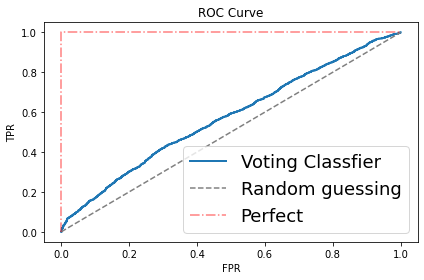

AUC: 0.5741


In [68]:
import matplotlib.pyplot as plt
proba = best_clf.predict_proba(X_test)
y_pred = best_clf.predict(X_test)
print('Misclassified samples: %d' % ((y_test != y_pred).sum()))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
## we use feature 1 as positive label
fpr, tpr, thresholds = roc_curve(y_test,
                                 proba[:, 1],
                                pos_label=1)

plt.plot(fpr, tpr, lw=2,
         label='Voting Classfier')
    
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='-.',
         alpha=0.5,
         color='red',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
plt.show()
print('AUC: %.4f' % auc(fpr, tpr))

In [69]:
X_test

,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count
13516,0.395170,28,10,33,1,1,1.407169e+09,1167
11607,0.456269,3,2,15,1,0,1.392888e+09,1016
11866,0.530358,7,3,10,1,0,1.366825e+09,115
25540,0.549880,31,11,29,1,1,1.382456e+09,974
26611,0.451092,28,1,7,1,0,1.389041e+09,51
...,...,...,...,...,...,...,...,...
20891,0.580642,7,30,9,1,1,1.411165e+09,1948
16842,0.475054,32,4,19,1,1,1.372183e+09,692
6085,0.590240,7,1,8,1,1,1.413884e+09,1774
7775,0.472952,31,1,13,1,0,1.363370e+09,72


In [70]:
df_real = pd.read_csv('../data/test.csv')

test_data = pd.DataFrame(columns=["title", "content", "tag", "channel", "fig_count", "link_count", "weekday", "month", "timestamp", "word_count"])
pgbar = progressbar.ProgressBar(widgets=['Progress: ',progressbar.Percentage(), ' ', progressbar.Bar('#'), progressbar.ETA()])
for i in pgbar(range(len(df_real))):
    title, content, tag, channel,  fig_count, link_count, weekday, month, timestamp, word_count = data_preprocess(df_real.loc[i,'Page content'])
    test_data = test_data.append({ 
                                    "title": title, 
                                    "content": content,
                                    "tag":  tag,
                                    "channel": channel, 
                                    "fig_count":  fig_count,
                                    "link_count":  link_count,
                                    "weekday":  weekday,
                                    "month": month,
                                    "timestamp":  timestamp,
                                    "word_count": word_count
                                    }, ignore_index=True)
    
test_data.head()
label_le = LabelEncoder()
test_data["channel"] = label_le.fit_transform(test_data["channel"].values)
test_data["word_count"] = label_le.fit_transform(test_data["word_count"].values)


Progress: 100% |#################################################|Time: 0:02:39


In [71]:
test_data

,title,content,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count
0,Soccer Star Gets Twitter Death Threats After T...,Note to humanity: One Direction fandom ai...,Entertainment Music One Direction soccer Sports,5,1,30,1,1,1.378756e+09,734
1,Google Glass Gets an Accessory Store,Shortly after announcing a hardware upgrade f...,Gadgets glass Google Google Glass Google Glass...,25,3,13,1,1,1.383212e+09,109
2,OUYA Gaming Console Already Sold Out on Amazon,"Well, that was quick. Just hours after going ...",amazon amazon kindle Business Gaming,2,2,13,1,1,1.372165e+09,122
3,'Between Two Ferns' Mocks Oscar Nominees,Between Two Ferns: Oscar Buzz Edition Part 1...,Between Two Ferns Movies The Oscars Oscars 201...,6,1,15,1,0,1.360726e+09,216
4,'American Sniper' Trailer: Looks Like Eastwood...,Ever since The Hurt Locker it seems like ...,American Sniper Awards Bradley Cooper clint ea...,5,1,10,1,1,1.412300e+09,183
...,...,...,...,...,...,...,...,...,...,...
11842,Check Out Twitter Co-Founders' Beautiful New O...,Some of the creators of Twitter have landed ...,biz stone evan williams me.dium Obvious Corp T...,25,3,12,0,0,1.360444e+09,124
11843,'Fish Out of Water' Is an Adorably Addictive i...,Full disclosure: Jetpack Joyride is still on...,Entertainment Gaming halfbrick iOS games Masha...,8,4,10,1,0,1.366312e+09,551
11844,"If Music Services Influenced Grammys, This Is ...",LOS ANGELES — Nominees for the 56th Grammy Aw...,56th Grammy Awards Entertainment The Grammys M...,18,10,33,1,0,1.390434e+09,1685
11845,"Google's Nexus 7 Comes to Europe, Australia an...",The latest version of Google's Nexus 7 has be...,Gadgets Google Nexus 7 Tech,25,2,11,1,1,1.377679e+09,88


In [72]:
# test_data = test_data[:]
# print( test_data)
names = ['title','content','tag']
for name, clf in zip(names, [pipe_title, pipe_content, pipe_tag]):
#     scores = cross_val_score(estimator=clf, X=X_train, y=y_train,
#                          cv=10, scoring='roc_auc')
#     print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))
    clf.fit(tmp_X, tmp_y)
#     y_pred = clf.predict(X_test)
    test_data[name] = clf.predict_proba(test_data)
#     print('Misclassified samples: %d' % ((y_test != y_pred).sum()))
#     print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

test_data = test_data.drop(columns=['title','content'])

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [76]:
tmp_X

,title,content,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count
3492,Analyst: iPad Air Sales May Top 3 Million This...,There may not be quite as many people waiting...,Apple Business Gadgets iPad iPad Air iPad Mini...,3,2,15,1,1,1.383328e+09,265
9375,Vice Raises $500 Million in Its Quest for 'Tot...,You can't spell avarice without Vice. CEO Sha...,Business Media VICE Media,3,2,8,1,1,1.409834e+09,364
17129,Twitter Shares Soar to Record on Optimism for ...,"Twitter Inc., the microblogging service that ...",Advertising Business Mobile Twitter,20,1,14,1,1,1.387937e+09,261
27200,John Oliver Is Leading the War Against Pumpkin...,The pumpkin spice obsession has gone too ...,Coffee John Oliver Last Week Tonight With John...,31,1,15,1,1,1.413211e+09,127
22507,10 Top News Stories This Week,It was another busy week at Mashable and in t...,CES Tech,28,21,39,0,0,1.358004e+09,1976
...,...,...,...,...,...,...,...,...,...,...
13123,The 7 Best Tech Companies to Work For,"Tech and social media are booming, and it see...",Business contributor Jobs Social Media Startup...,3,4,33,1,0,1.390824e+09,771
19648,Artist Creates Detailed Post-Zombie-Apocalypse...,If you live in Seattle and you're worried ab...,Apocalypse kickstarter U.S. World zombies,32,1,15,1,0,1.361990e+09,216
9845,Oculus Rift Now Lets You Ride the 'Back to the...,Fans of Back to the Future II have always...,Apps and Software Dev & Design Movies Gadgets ...,10,1,17,1,0,1.398052e+09,292
10799,Holographic Display Made for $10,Technophiles have dreamed of three-dimensiona...,Dev & Design development display displays Gadg...,28,1,19,1,1,1.372298e+09,498


In [74]:
test_data

,tag,channel,fig_count,link_count,weekday,month,timestamp,word_count
0,0.572572,5,1,30,1,1,1.378756e+09,734
1,0.392634,25,3,13,1,1,1.383212e+09,109
2,0.629334,2,2,13,1,1,1.372165e+09,122
3,0.606551,6,1,15,1,0,1.360726e+09,216
4,0.719135,5,1,10,1,1,1.412300e+09,183
...,...,...,...,...,...,...,...,...
11842,0.519294,25,3,12,0,0,1.360444e+09,124
11843,0.538046,8,4,10,1,0,1.366312e+09,551
11844,0.400876,18,10,33,1,0,1.390434e+09,1685
11845,0.470888,25,2,11,1,1,1.377679e+09,88


In [75]:
result = best_clf.predict_proba(test_data)
out = pd.DataFrame({ 'Id': df_real.Id,'Popularity': result[:, 1]})
print(out)
out.to_csv('./output/predict.csv', index=False)

          Id  Popularity
0      27643    0.366392
1      27644    0.575794
2      27645    0.317049
3      27646    0.296103
4      27647    0.251608
...      ...         ...
11842  39485    0.736621
11843  39486    0.466100
11844  39487    0.619772
11845  39488    0.442221
11846  39489    0.418986

[11847 rows x 2 columns]


0.56425 testing AUC